Using Theano backend.


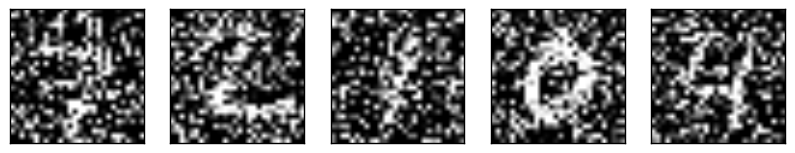

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 82s - loss: 0.2869 - val_loss: 0.2333
Epoch 2/10
60000/60000 [==============================] - 82s - loss: 0.2207 - val_loss: 0.2099
Epoch 3/10
60000/60000 [==============================] - 82s - loss: 0.2058 - val_loss: 0.2006
Epoch 4/10
60000/60000 [==============================] - 82s - loss: 0.1971 - val_loss: 0.1923
Epoch 5/10
60000/60000 [==============================] - 82s - loss: 0.1909 - val_loss: 0.1882
Epoch 6/10
60000/60000 [==============================] - 82s - loss: 0.1859 - val_loss: 0.1836
Epoch 7/10
60000/60000 [==============================] - 82s - loss: 0.1815 - val_loss: 0.1767
Epoch 8/10
60000/60000 [==============================] - 82s - loss: 0.1781 - val_loss: 0.1737
Epoch 9/10
60000/60000 [==============================] - 82s - loss: 0.1749 - val_loss: 0.1749
Epoch 10/10
60000/60000 [==============================] - 82s - loss: 0.1724 - val_lo

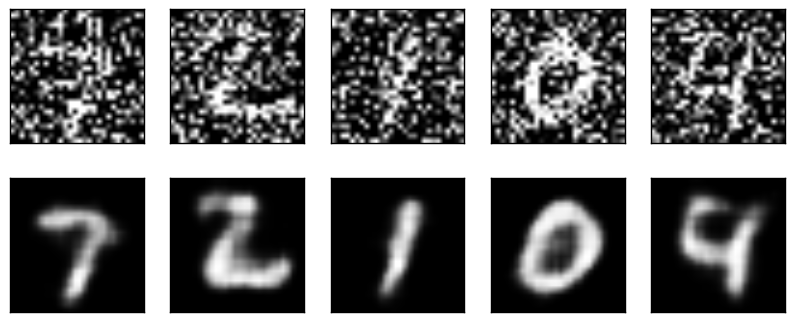

In [1]:
'''
Copyright

Jelen forráskód a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott
"Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.

A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning

A forráskódot GPLv3 licensz védi. Újrafelhasználás esetén lehetőség szerint kérejük
az alábbi szerzőt értesíteni.

2016 (c) Csapó Tamás Gábor (csapot kukac tmit pont bme pont hu)


Original Denoising AutoEncoder example from:

Links:
    [MNIST Dataset] http://yann.lecun.com/exdb/mnist/
    [Keras Denoising AutoEncoder] https://blog.keras.io/building-autoencoders-in-keras.html
'''

from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

# MNIST mérete
input_img = Input(shape=(1, 28, 28))

# encoder rész, ReLU aktivációs függvénnyel
x = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# modell az encoder-re
encoder = Model(input=input_img, output=encoded)

# itt (8 x 4 x 4) azaz 128-dimenziós reprezentáció


# decoder rész, ReLU + végén szigmoid aktivációs függvénnyel
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(8, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(16, 3, 3, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

# modell a teljes AutoEncoder-re (encoder+decoder)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


# train-test adatok

from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

# tanítóadatokhoz zaj keverése
noise_factor = 0.7
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 5  # 5 db digit
plt.figure(figsize=(10, 4))
for i in range(n):
    # ábra: zajos képek
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# tanítás
autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

decoded_imgs = autoencoder.predict(x_test_noisy)

n = 5  # 5 db digit
plt.figure(figsize=(10, 4))
for i in range(n):
    # ábra: zajos képek
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # ábra: visszaállított képek
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()